<a href="https://colab.research.google.com/github/achmadbauravindah/TextClassification-LSTM-TwitterSentimentDataset/blob/main/TextClassification_LSTM_TwitterSentimentDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Achmad Bauravindah

Email: baurav99@gmail.com

Asal: Pasuruan, Jawa Timur

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Embedding, Dropout
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger # Callback
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Download data from kaggle 
_ = ! git clone https://github.com/achmadbauravindah/ravin_kaggle_credential.git # get credential from kaggle
_ = ! pip install kaggle # install kaggle on drevice
_ = ! mkdir ~/.kaggle # make hidden folder .kaggle to configure credential
_ = ! cp ravin_kaggle_credential/kaggle.json ~/.kaggle/ # copy credential from github to .kaggle folder
_ = ! chmod 600 ~/.kaggle/kaggle.json # change access
_ = ! kaggle datasets download twitter-sentiment-analysis # which dataset to download
_ = ! unzip twitter-sentiment-analysis # unzip if data zipped

In [ ]:
# Get data from direktori
data_path = 'Twitter_Data.xlsx'
data = pd.read_excel(data_path)

In [ ]:
# Show dataframe
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


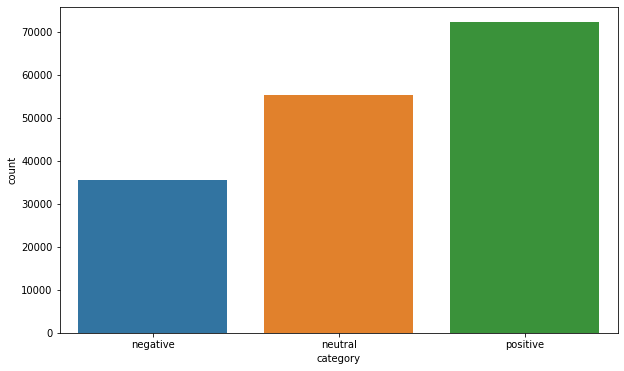

In [ ]:
# Persebaran Label data
plt.figure(figsize=(10,6))
sns.countplot(x='category', data=data)

In [ ]:
# One-Hot Encoding Process of Label data
category = pd.get_dummies(data['category'])
data = pd.concat([data, category], axis=1)
data = data.drop(columns='category')

In [ ]:
# Cek jumlah data
data.count()

clean_text    162966
negative      162966
neutral       162966
positive      162966
dtype: int64

In [ ]:
# Show data after One-Hot Encoding of Label (Sentiment Column)
data.head()

,clean_text,negative,neutral,positive
0,when modi promised “minimum government maximum...,1,0,0
1,talk all the nonsense and continue all the dra...,0,1,0
2,what did just say vote for modi welcome bjp t...,0,0,1
3,asking his supporters prefix chowkidar their n...,0,0,1
4,answer who among these the most powerful world...,0,0,1


In [ ]:
# Split Sentence and Label (Sentiment)
sentences = data['clean_text'].values
label = data[['negative', 'neutral', 'positive']].values

In [ ]:
# Split data training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2)

In [ ]:
# Preprocessing data

# Tokenization data
tokenizer = Tokenizer(num_words=5000, oov_token='x') # Model Tokenizer
# Train
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_val) 
# Texts/Sentences To Sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
 
# Padding data
X_train = pad_sequences(X_train) 
X_val = pad_sequences(X_val)

In [ ]:
# Create Callback

# 1 Callback untuk mendapatkan checkpoint setiap akurasi yang membaik dari tiap epoch
checkpoint_filepath = '/content/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpointCallback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True)

# 2 Callback untuk menghentikan proses training pada rentang akurasi tertentu (di-set 100%)
class stopTrainingCallback(Callback):
  def on_epoch_end(self, epoch,logs={}):
    if ((logs.get('accuracy') >= 0.9) and (logs.get('val_accuracy') >= 0.9)) :
      print('\n Yeyy Akurasimu mencapai 90% 🤩')
      self.model.stop_training = True

# 3 Callback mendapatkan accuracy, loss, val_loss, val_accuracy dan disimpan pada csv
log_csv = CSVLogger('text_classification_twitter_result.csv', separator=';', append=False)

In [ ]:
callback_list = [checkpointCallback, stopTrainingCallback(), log_csv]

In [ ]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(128),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 179,203
Trainable params: 179,203
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30
history = model.fit(X_train, y_train, epochs=num_epochs, 
                    validation_data=(X_val, y_val), verbose=1, batch_size=256, callbacks=callback_list)

Epoch 1/30
510/510 [==============================] - 169s 320ms/step - loss: 0.5524 - accuracy: 0.7730 - val_loss: 0.3113 - val_accuracy: 0.8994
Epoch 2/30
510/510 [==============================] - ETA: 0s - loss: 0.2579 - accuracy: 0.9178
 Yeyy Akurasimu mencapai 90% 🤩
510/510 [==============================] - 142s 278ms/step - loss: 0.2579 - accuracy: 0.9178 - val_loss: 0.2237 - val_accuracy: 0.9356


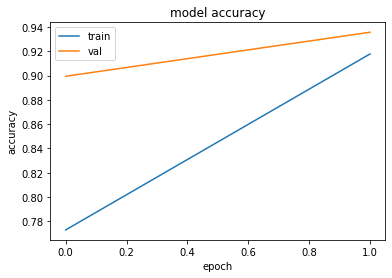

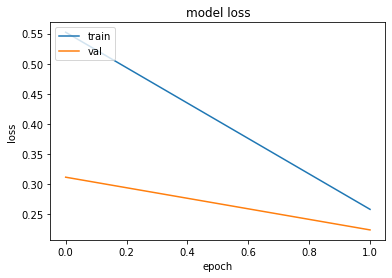

In [ ]:
# Show history of accuracy training model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# Show history of loss training model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()